## Student Name: Claire Morley

---

# Tutorial 2 - Part II: Bayesian mixture modeling

All the parts that require action (either in the code or equations) are flagged by `<your turn>` or $\color{red}{<your~turn>}$

In [98]:
import numpy as np
import scipy.stats as st
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import matplotlib.pylab as plt

sns.set_style("darkgrid")
sns.set_context("talk")
sns.color_palette("hls", 8)

# Setting matplotlib fonts
from matplotlib import rc
font = {'family': 'serif',
        'weight': 'bold',
        'size': '14'}
rc('font', **font)


# Below is a set of colors for matplotlib that is colorblind-friendly
# To use them in plotting commands, you can simply set "color=colorset[N]",
# where N is an integer in [0,16), reflecting the index of the colors below.
colorset = ['#000000','#00270C','#00443C','#005083',
            '#034BCA','#483CFC','#9C2BFF','#EB24F4',
            '#FF2DC2','#FF4986','#FF7356','#FFA443',
            '#EBD155','#D3F187','#D7FFC8','#FFFFFF']

## Mixture modeling

Starting with the example in the lecture, we have made $N$ independent measurements of a quantity $Y$ (with each measurement containing normally-distributed uncertainties), at different values of quantity $X$. Assuming $Y$ as a function of $X$, we want to infer a model for the "model" $Y$ (which we label $Y_{\rm{Model}}$), given what we can *observe* as $Y$ ($Y_{\rm{obs}}$).

### Data

Our data consists of a sample a single quantity per measurement:


$$ \hat{X} = [\hat{x}_1,\cdots,\hat{x}_N] $$


In this unit we will use [Pandas](https://pandas.pydata.org/) for data operations. Here is [a quick cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf) for using Pandas.

In [99]:
DATA = pd.read_csv('https://raw.githubusercontent.com/bersavosh/P4003/refs/heads/main/Tutorials/T2_data_mixture.csv')
DATA.describe()

,x
count,350.000000
mean,7.102849
std,4.785521
min,0.209487
25%,1.748436
50%,8.051746
75%,11.132838
max,18.768397


### EDA
#### Exercise: Make a histogram and a kde plot the measurements using [Seaborn](https://seaborn.pydata.org/tutorial/distributions.html). Include a rug visualization in both. For the histogram, assign binning so that you have a total of 50 bins. For the KDE plot, set bandwidth to be 0.25.

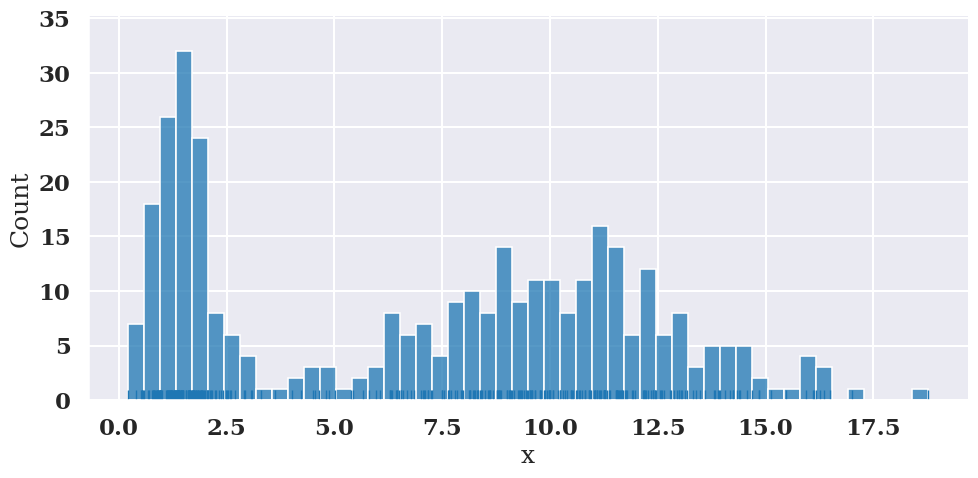

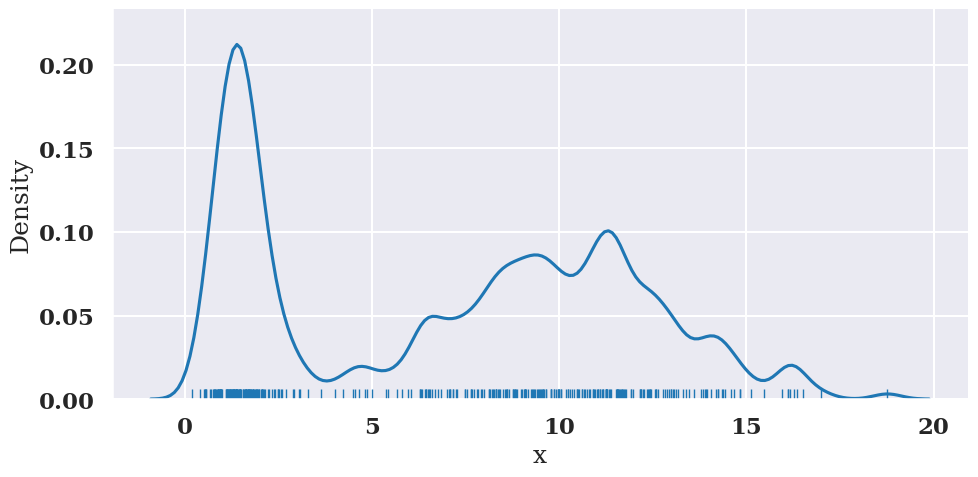

In [100]:
# <your turn>
## Two plots should be produced
# plt.figure(1)
# sns.histplot(DATA,bins=50)
# sns.rugplot(DATA)
#OR
sns.displot(DATA,x='x',kind='hist',bins=50, rug=True,aspect=2)
# plt.figure(2)
# sns.kdeplot(DATA,bw_adjust=2)
# sns.rugplot(DATA)
sns.displot(DATA,x='x',kind='kde',bw_adjust=0.25, rug=True,aspect=2)

### Our model

Similar to the lecture, we consider that our observed values of X are random draws from a *mixture* of two gaussians:
$$ \hat{X}\sim \rm{Mixture}\{\rm{Normal}(\mu_1, \sigma_1),\rm{Normal}(\mu_2, \sigma_2)\} $$


So:

$$ p(\hat{X} |\mu_1,\sigma_1,w_1,\mu_2,\sigma_2,w_2) = \prod_{i=1}^{N}\left[\sum_{j=1}^{2} w_j \rm{Normal}(\mu_j,\sigma_j|\hat{x}_i)\right] $$

$$ \mu_j \sim \textrm{Uniform}(\min=0.0,\max=20) $$
$$ \sigma_j \sim \textrm{Uniform}(\min=0.1,\max=10) $$
$$ [w_1,w_2] \sim \textrm{Dir}([w_1,w_2];[\alpha_1=1,\alpha_2=1]) $$




#### Exercise: Build a PyMC model with the variables above. With the following steps:
 - Start with the data. Data can be defined in a PyMC model using `pm.Data`.
 - Then add the model parameters and variables we have defined above.
 - Then, have a look at the [Mixture](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Mixture.html) documentation and define your mixture components and likelihood.
 - It is always helpful to plot the plate notation of the model to see how our model is structured, based on what we did in our linear regression tutorial, plot a plate notation for the model.

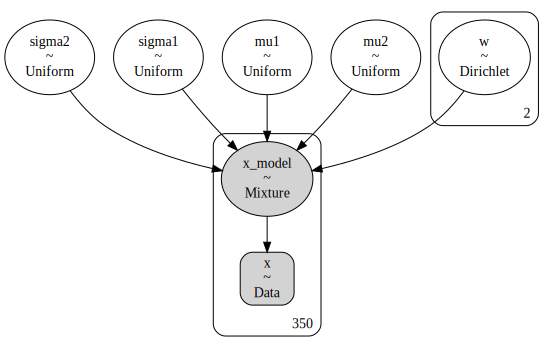

In [101]:
# <your turn>
# define the model and its components, and visualize the plate notation

with pm.Model() as mixture_model:
    ## First define your data here:
    x = pm.Data('x',DATA['x'])

    ## Now define your model variables
    mu1 = pm.Uniform('mu1',lower=0,upper=20)
    mu2 = pm.Uniform('mu2',lower=0,upper=20)
    sigma1 = pm.Uniform('sigma1',lower=0.1,upper=10)
    sigma2 = pm.Uniform('sigma2',lower=0.1,upper=10)
    #bivariate quantity - pymc has a dirichlet thing
    w = pm.Dirichlet('w',a=np.array([1,1]))

    ## Mixture components and likelihood
    mixture_components = [pm.Normal.dist(mu=mu1,sigma=sigma1),pm.Normal.dist(mu=mu2,sigma=sigma2)]

    mixture_likelihood = pm.Mixture("x_model", w=w, comp_dists=mixture_components, observed=x)

## plate notation
pm.model_to_graphviz(mixture_model)


### Prior and prior-predictive sampling

#### Exercise: with the model defined above, perform prior and prior-predictive sampling with 1000 draws and save the output as an inference data object.

In [102]:
# <your turn>

with mixture_model:
    mixture_mcmc_sample_prior_predictive = pm.sample_prior_predictive(draws=1000)

mixture_mcmc_sample_prior_predictive

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

#### Exercise: plot marginal and pair-wise distribution of prior samples. You can use the commands we explored in previous workshop, passing the inference data and indicating `group='prior'`. Explore if the results are as expected based on our model definitions.

array([[<Axes: ylabel='mu1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='mu2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='w\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='mu1', ylabel='w\n1'>, <Axes: xlabel='mu2'>,
        <Axes: xlabel='sigma1'>, <Axes: xlabel='sigma2'>,
        <Axes: xlabel='w\n0'>, <Axes: xlabel='w\n1'>]], dtype=object)

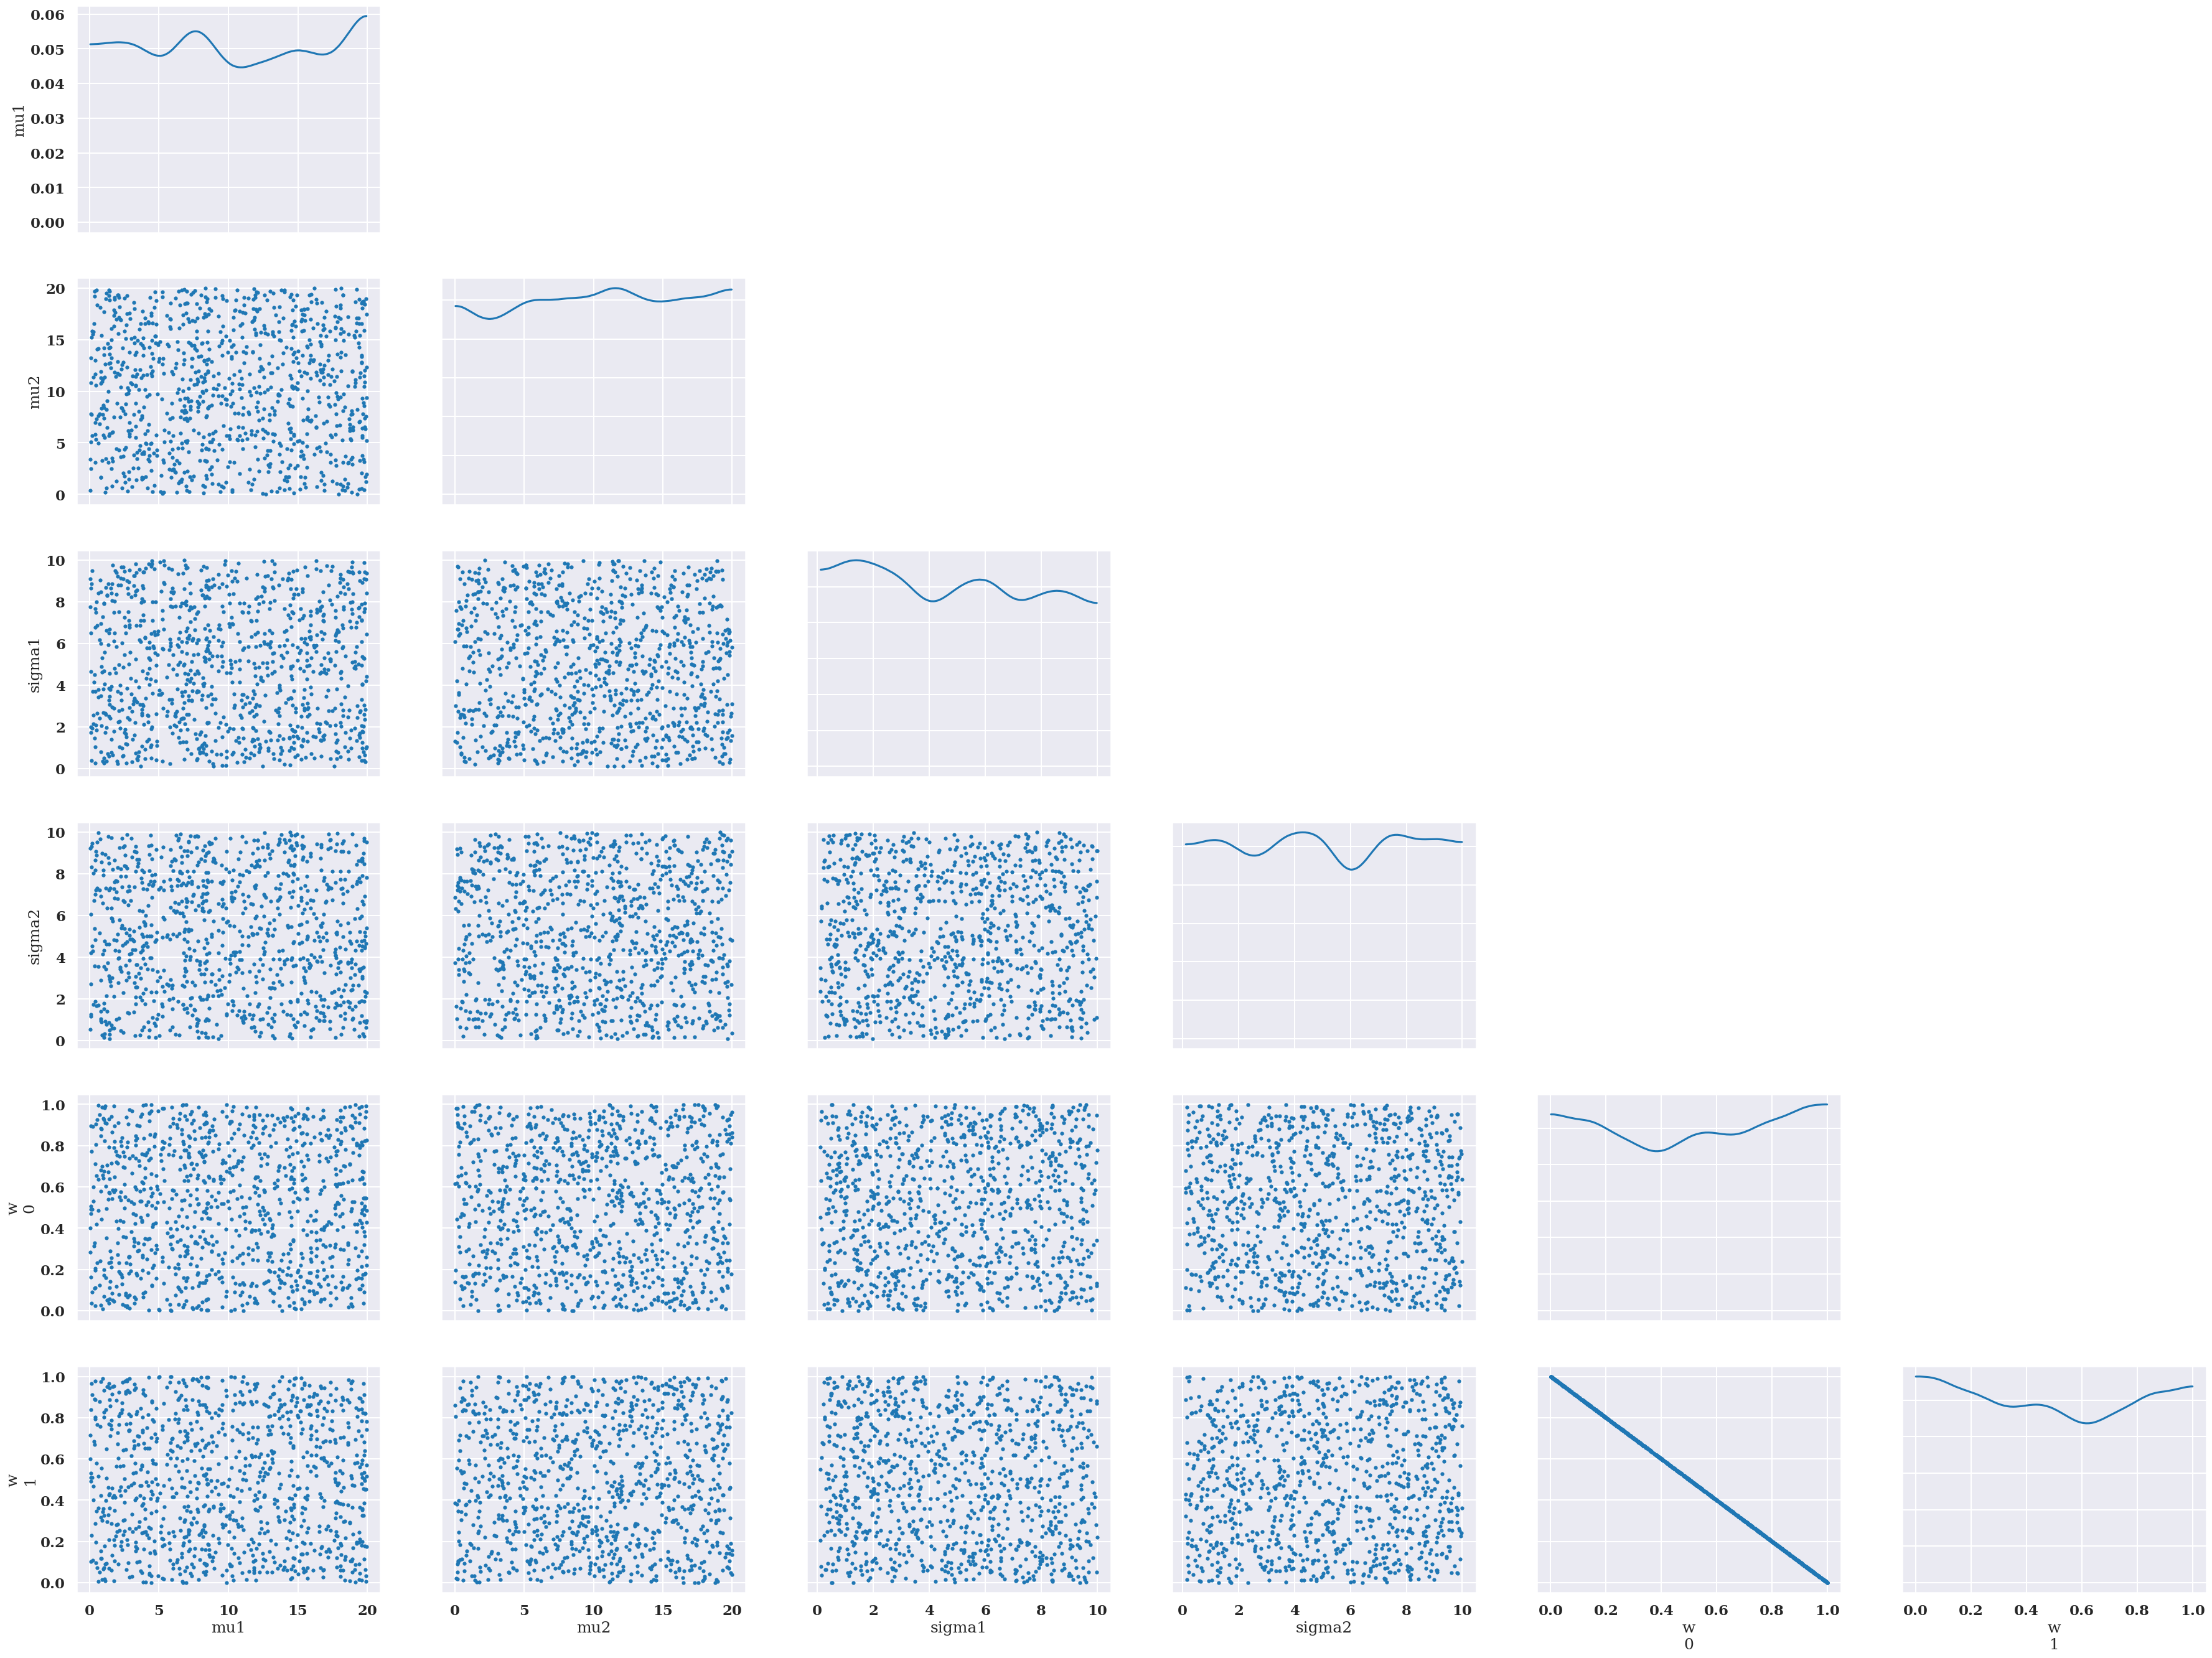

In [103]:
# <your turn>
## Two plots should be produced.

az.plot_pair(data=mixture_mcmc_sample_prior_predictive,group='prior',marginals=True)


#### Exercise: plot empirical cumulative distribuion function of the data with the functionalities defined in [Arviz](https://python.arviz.org/en/stable/examples/index.html). Assign the output figure object to python variable `ax_cdf`.
**Hint**: you can use the pandas data frame directly which contains the data, or use the `constant_data` group in your inference data object, and extract the values using `to_numpy()`.

/usr/local/lib/python3.11/dist-packages/arviz/plots/ecdfplot.py:298: BehaviourChangeWarning: In future versions, if `eval_points` is not provided, then the ECDF will be evaluated at the unique values of the sample. To keep the current behavior, provide `eval_points` explicitly.
  warnings.warn(


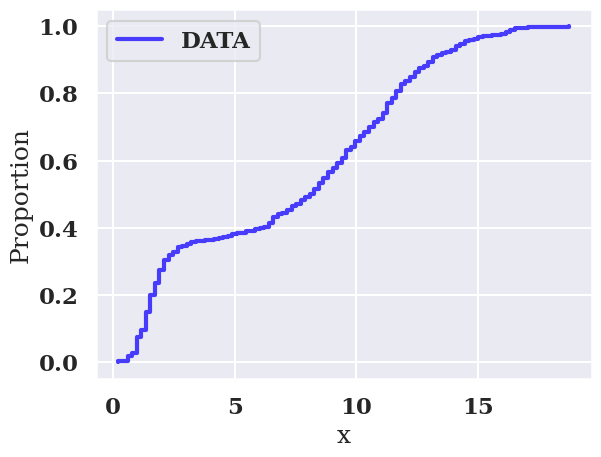

In [104]:
# <your turn>
mixture_mcmc_sample_prior_predictive.constant_data['x'].to_numpy()
ax_cdf = az.plot_ecdf(values=mixture_mcmc_sample_prior_predictive.constant_data['x'].to_numpy(),plot_kwargs={'color': colorset[5],'label':'DATA','lw':3})

ax_cdf.legend()
ax_cdf.set_xlabel('x')
ax_cdf.set_ylabel('Proportion');

#### Exercise: Repeat the step above, and plot ECDF of the prior predictive sample on top of the ECDF of the data.

**Hint**: you can pass `ax=ax_cdf` in the subsequent plotting commands for plottings to occur on the same canvas as where you plot your data.

**Hint**: Our case here is a bit challenging, how would we go about visualizing more than one set of our prior samples? First have a look at navigating subsets within inference data sets. E.g., look at the functionality of `sel` in the [documentation](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html#get-a-subset-of-chains).

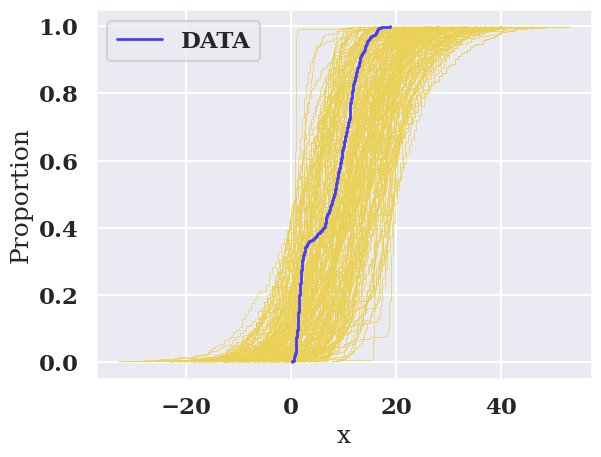

In [105]:
# <your turn>
## add as many commands and definitions as you need in this cell

# mixture_mcmc_sample_prior_predictive.prior_predictive['x_model'].sel(chain=0,draw=0)
ax_cdf = az.plot_ecdf(values=mixture_mcmc_sample_prior_predictive.constant_data['x'].to_numpy(),plot_kwargs={'color': colorset[5],'lw':2,'label':'DATA','zorder':100})
for random_index in np.random.randint(0,1000,200):
  az.plot_ecdf(values=mixture_mcmc_sample_prior_predictive.prior_predictive['x_model'].sel(chain=0,draw=random_index).to_numpy(),ax=ax_cdf,plot_kwargs={'color': colorset[12],'lw':0.5})


ax_cdf.legend()
ax_cdf.set_xlabel('x')
ax_cdf.set_ylabel('Proportion');

#### Exercise: Similar to above, make KDE plots of the prior predictive samples on top of the KDE of the data. For this exercise, don't use Seaborn and instead use `plot_kde` in arviz. Use a bandwidth of 0.25 for all KDEs.

In [106]:
# <your turn>
## add as many commands and definitions as you need in this cell

ax_kde =





ax_kde.legend()
ax_kde.set_xlabel('x')
ax_kde.set_ylabel('p(x)')

SyntaxError: invalid syntax (ipython-input-353191649.py, line 4)

### Sampling from the posterior

#### Exercise: perform sampling from the posterior with the model we defined above with 2000 draws post warm-up ("tuning") on 4 chains, and warm-up sample size of 1000. Use `discard_tuned_samples=False`.

In [107]:
# <your turn>

with mixture_model:
    mixture_mcmc_sample = pm.sample(tune=1000,discard_tuned_samples=False, draws=2000, chains=4)

mixture_mcmc_sample

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Warmup iterations saved (warmup_*).

#### Exercise: Print a summary table of the posterior samples with methods we explored last week. Think about what the values in the summary table mean. Use 95% HDI probability for interval estimation.

In [108]:
# <your turn>

fit_summary = pm.summary(mixture_mcmc_sample, hdi_prob=0.95)

fit_summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,5.788,4.316,1.355,10.406,2.152,0.002,6.0,109.0,1.73
mu2,5.788,4.317,1.360,10.400,2.153,0.002,6.0,109.0,1.73
sigma1,1.793,1.234,0.474,3.265,0.613,0.001,6.0,126.0,1.73
sigma2,1.789,1.231,0.480,3.260,0.612,0.001,6.0,113.0,1.73
w[0],0.500,0.154,0.304,0.693,0.076,0.000,6.0,102.0,1.73
w[1],0.500,0.154,0.307,0.696,0.076,0.000,6.0,102.0,1.73


#### Exercise: Is everything looking reasonable in the table you produced? Plot the "traces" of your chains and look at how your chains have stepped through the parameter space (for all parameters). First do this for `warmup_posterior`, then for `posterior` (the default). Do you notice anything unusual?

In [ ]:
# <your turn>

# Warmup trace
az.plot_trace(mixture_mcmc_sample.warmup_posterior)
az.plot_trace(mixture_mcmc_sample)

# post-warm-up trace




### Workflow loop of modification

If you have identified any issues with your model, redefine them blow and rerun the steps outline.

#### Exercise - Step 1: redefine your statistical model with the potential improvement and print plate notation again. Note that we are using a new name for our new model `updated_mixture_model` compared to what we called `mixture_model` above.

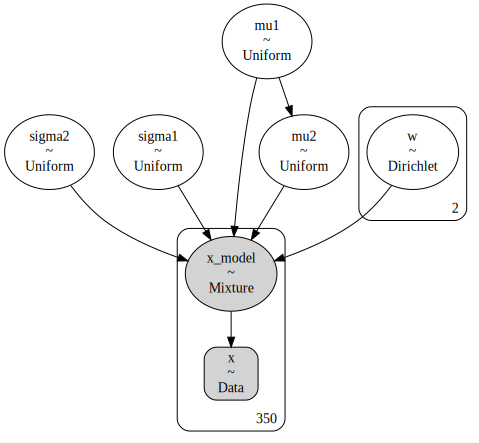

In [112]:
# <your turn>
# just define the model and its components, no sampling or plotting needed here.


with pm.Model() as updated_mixture_model:
    ## First define your data here:
    x = pm.Data('x',DATA['x'])

    ## Now define your model variables
    mu1 = pm.Uniform('mu1',lower=0,upper=20)
    mu2 = pm.Uniform('mu2',lower=mu1,upper=20)
    sigma1 = pm.Uniform('sigma1',lower=0.1,upper=10)
    sigma2 = pm.Uniform('sigma2',lower=0.1,upper=10)
    #bivariate quantity - pymc has a dirichlet thing
    w = pm.Dirichlet('w',a=np.array([1,1]))

    ## Mixture components and likelihood
    mixture_components = [pm.Normal.dist(mu=mu1,sigma=sigma1),pm.Normal.dist(mu=mu2,sigma=sigma2)]

    mixture_likelihood = pm.Mixture("x_model", w=w, comp_dists=mixture_components, observed=x)

## plate notation
pm.model_to_graphviz(updated_mixture_model)

#### Exercise - Step 2: perform prior predictive sampling with the new model with 1000 draws and plot pair-wise plot of the posteriors and include marginal distributions. Compare the results with what we had in our previous model.

array([[<Axes: ylabel='mu1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='mu2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='w\n0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='mu1', ylabel='w\n1'>, <Axes: xlabel='mu2'>,
        <Axes: xlabel='sigma1'>, <Axes: xlabel='sigma2'>,
        <Axes: xlabel='w\n0'>, <Axes: xlabel='w\n1'>]], dtype=object)

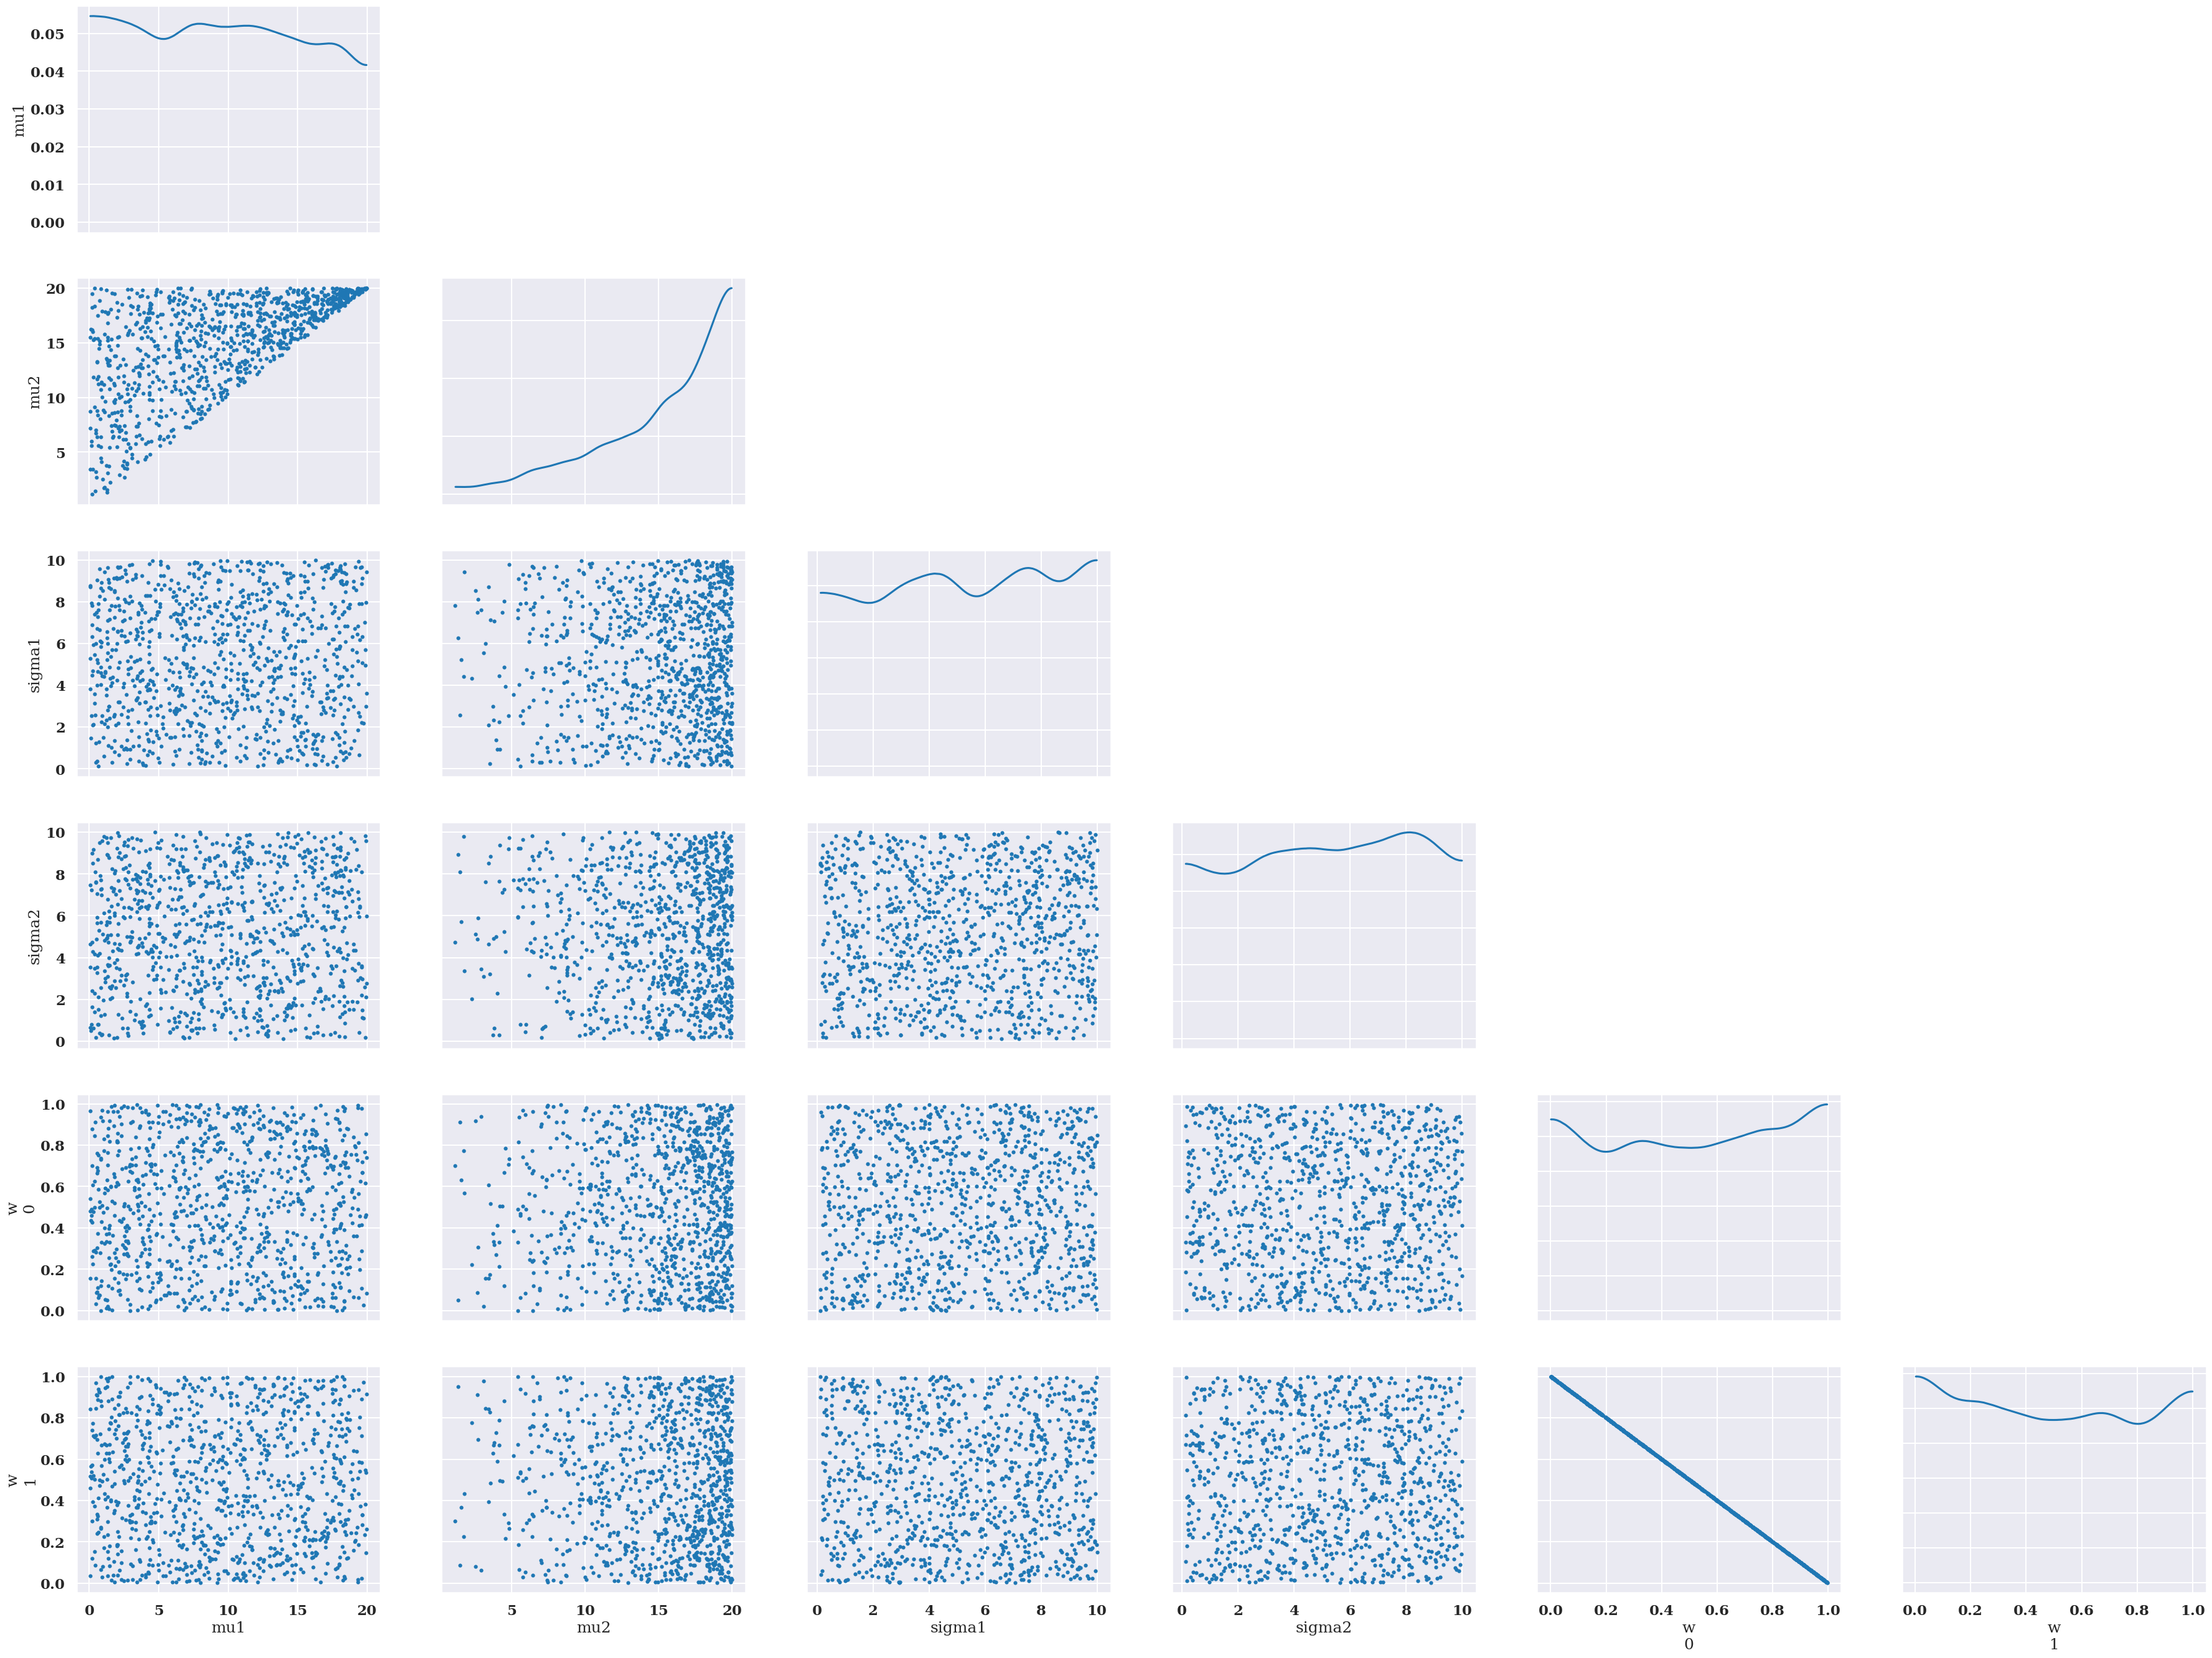

In [113]:
# <your turn>

with updated_mixture_model:
    updated_mixture_mcmc_sample_prior_predictive = pm.sample_prior_predictive(draws=1000)

## Pairwise plot:
az.plot_pair(updated_mixture_mcmc_sample_prior_predictive,group='prior',marginals=True)


You can plot the ECDFs as well, but we leave that for now.

#### Exercise - Step 3: perform sampling from the posterior with the updated model we defined above with 2000 draws post warm-up ("tuning") on 4 chains, and warm-up sample size of 1000. Use `discard_tuned_samples=False`.

In [115]:
# <your turn>

with updated_mixture_model:
    updated_mixture_mcmc_sample = pm.sample(tune=1000,chains=4, draws=2000, discard_tuned_samples=False)

updated_mixture_mcmc_sample

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Warmup iterations saved (warmup_*).

#### Exercise - step 4: Print a summary table of the posterior sample from our updated model. Use 95% HDI probability for interval estimation. Do the values look promising?

In [116]:
# <your turn>

updated_fit_summary = pm.summary(updated_mixture_mcmc_sample)
updated_fit_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,1.475,0.055,1.368,1.576,0.001,0.001,8994.0,6418.0,1.0
mu2,10.098,0.211,9.691,10.474,0.002,0.002,8331.0,6202.0,1.0
sigma1,0.564,0.045,0.480,0.646,0.000,0.000,8158.0,6762.0,1.0
sigma2,3.021,0.166,2.716,3.333,0.002,0.002,8871.0,6153.0,1.0
w[0],0.348,0.026,0.299,0.397,0.000,0.000,9987.0,6663.0,1.0
w[1],0.652,0.026,0.603,0.701,0.000,0.000,9987.0,6663.0,1.0


#### Exercise - step 5: plot the sampling traces for both warm up and post-warm-up samples. Assess the sampling.

In [ ]:
# <your turn>

# Warmup trace



# post-warm-up trace




### Inspecting posteriors and influence of priors

#### Exercise: Make a pair-wise plot of the posterior samples (including marginal KDEs). Do they look reasonable?

In [ ]:
# <your turn>



#### Exercise: In the cell below, we append the prior samples we generated at the beginning to our new `updated_mixture_mcmc_sample` inference data. Using this, generate plots comparing priors to posteriors for model parameters and evaluate the influence of priors. For this exercise, make two plots: 1- distribution comparison with `plot_dist_comparison`, 2- use pair-wise plot, overlaying both priors and posteriors.

In [ ]:
# No action needed in this cell, just run it once!

updated_mixture_mcmc_sample.extend(mixture_mcmc_sample_prior_predictive)
updated_mixture_mcmc_sample

In [ ]:
# <your turn>

## distribution comparison plot



## Pair-wise comparison plot




### Posterior predictive sampling

#### Exercise: perform posterior predictive sampling (make sure to use `extend_inferencedata=True`), and use the same method as we visualized the prior predictive sample for visualization.

In [ ]:
# <your turn>: cell 1 - sampling

with updated_mixture_model:
    # sampling posterior predictive and extending the updated_mixture_mcmc_sample


# If done correctly, you should see the group in the inference data
updated_mixture_mcmc_sample

In [ ]:
# <your turn>: cell 2 - plotting CDF

ax_cdf =




ax_cdf.legend()
ax_cdf.set_xlabel('x')
ax_cdf.set_ylabel('Proportion')

In [ ]:
# <your turn>: cell 3 - plotting KDE

ax_kde =




ax_kde.legend()
ax_kde.set_xlabel('x')
ax_kde.set_ylabel('p(x)')

Now that we are hopefully satisfied, let's explore the posterior results:

#### Exercise: using plotting functions we have discussed in earlier exercises, plot the marginal posterior samples for our parameters with poist and interval estimates plotted on top. Use median for point estimate and 95% HDI for interval estimation.

In [ ]:
# <your turn>




## You can now save the notebook and download it.